In [11]:
import os
import numpy as np
from tqdm.notebook import tqdm

In [559]:
from neuroCombat import neuroCombat
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

In [2]:
import matplotlib.pyplot as plt

In [19]:
import pandas as pd

# CCC Power Analysis

### Utils

In [3]:
def permutation_test(x1, x2, stat_fn, num_permutations=10000):
    
    true_stat = stat_fn(x1, x2)
    
    perm_stats = [true_stat]
    
    for i in range(num_permutations-1):
        
        perm_x2 = np.random.permutation(x2)
        perm_stat = stat_fn(x1, perm_x2)
        
        perm_stats.append(perm_stat)
        
    return (np.array(perm_stats)>=true_stat).mean()
    

In [4]:
def ccc(x1, x2, e = 1e-12):

    mean_1 = np.mean(x1)
    mean_2 = np.mean(x2)
    
    var_1 = (np.std(x1)**2)
    var_2 = (np.std(x2)**2)

    covar_12 = np.mean((x1-mean_1)*(x2-mean_2))
    
    numerator = 2 * covar_12
    denominator = var_1 + var_2 + (mean_1 - mean_2)**2
    

    return numerator/(denominator+e)

In [5]:
def get_random_samples(ccc_threshold=0.85, n_samples=52):
    
    mean = [0,0]
    cov = [[1,ccc_threshold],[ccc_threshold,1]]
    
    samples = np.random.multivariate_normal(mean, cov, size=n_samples)
    
    x1, x2 = samples[:,0], samples[:,1]
    
    return x1, x2

### E(CCC) = 0.70

In [505]:
verbose = False

alpha = 0.05
ccc_threshold = 0.70

num_simulations = 1_000
num_permutations = 1_000

test_sample_sizes = range(2,62, 2) # 2,4,6,...,60

true_num_samples = 52

power_hist = []
samples_hist = []

for num_samples in tqdm(test_sample_sizes):

    p_values = []

    for i in range(num_simulations):

        x1, x2 = get_random_samples(ccc_threshold, n_samples=num_samples)
        p = permutation_test(x1, x2, ccc, num_permutations=num_permutations)

        p_values.append(p)
    
    power = (np.array(p_values)<=alpha).mean()
    
    if verbose: 
        print(f"For {num_samples}, Power= {power}")
    
    power_hist.append(power)
    samples_hist.append(num_samples)

  0%|          | 0/30 [00:00<?, ?it/s]

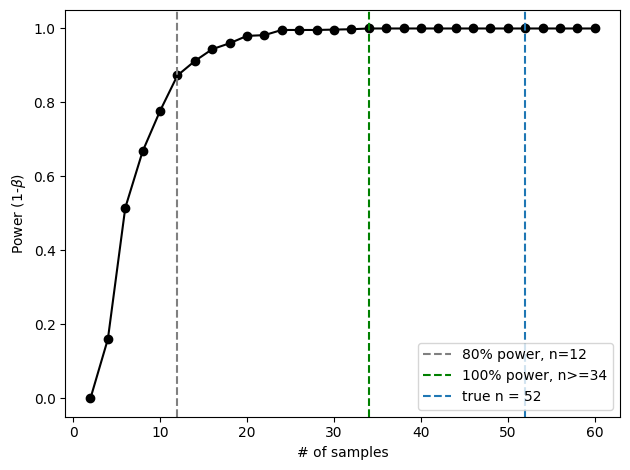

In [549]:
true_num_samples = 52
plt.plot(samples_hist, power_hist, linestyle="-", marker='o', color='black')
plt.xlabel("# of samples")
plt.ylabel(r"Power (1-$\beta$)")


plt.axvline(x=samples_hist[np.argmax(np.array(power_hist)>=0.80)], linestyle='--', label=f"80% power, n={samples_hist[np.argmax(np.array(power_hist)>=0.80)]}", color='gray')
plt.axvline(x=samples_hist[np.argmax(power_hist)], linestyle='--', label=f"100% power, n>={samples_hist[np.argmax(power_hist)]}", color='green')
plt.axvline(x=true_num_samples, linestyle='--', label="true n = 52")

plt.legend() #loc='lower right')
plt.tight_layout()

### E(CCC) = 0.85

In [6]:
OUT_DIR = "results"

In [8]:
verbose = False

alpha = 0.05
ccc_threshold = 0.85

num_simulations = 1_000
num_permutations = 1_000

test_sample_sizes = range(2,62,2) # 2,4,6,...,60

true_num_samples = 52

power_hist = []
samples_hist = []

for num_samples in tqdm(test_sample_sizes):

    p_values = []

    for i in range(num_simulations):

        x1, x2 = get_random_samples(ccc_threshold, n_samples=num_samples)
        p = permutation_test(x1, x2, ccc, num_permutations=num_permutations)

        p_values.append(p)
    
    power = (np.array(p_values)<=alpha).mean()
    
    if verbose: 
        print(f"For {num_samples}, Power= {power}")
    
    power_hist.append(power)
    samples_hist.append(num_samples)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
#how many samples do you need to achieve your alpha and beta, to correctly observe a ccc of 0.85. 

#The total sample size needed to assess whether the CCC is significantly different from zero (i.e., statistically significant) when the expected CCC is 0.85."

In [12]:
results = dict(zip(samples_hist, power_hist))
np.save(os.path.join(OUT_DIR, "power_outputs.npy"), results, allow_pickle=True)

In [555]:
results = np.load(os.path.join(OUT_DIR, "power_outputs.npy"), allow_pickle=True).item()

In [557]:
samples_hist = list(results.keys())
power_hist = list(results.values())

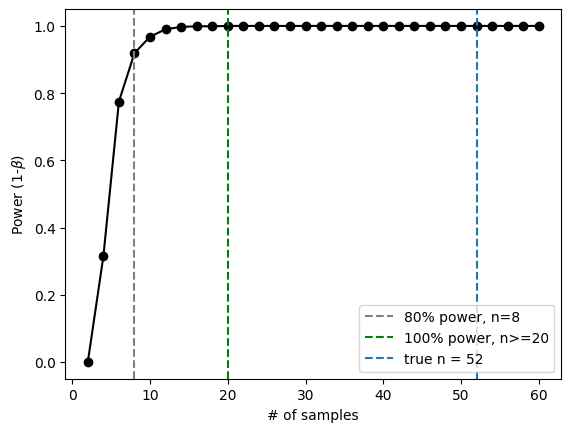

In [558]:
plt.plot(samples_hist, power_hist, linestyle="-", marker='o', color='black')
plt.xlabel("# of samples")
plt.ylabel(r"Power (1-$\beta$)")
plt.axvline(x=samples_hist[np.argmax(np.array(power_hist)>=0.80)], linestyle='--', label=f"80% power, n={samples_hist[np.argmax(np.array(power_hist)>=0.80)]}", color='gray')
plt.axvline(x=samples_hist[np.argmax(power_hist)], linestyle='--', label=f"100% power, n>={samples_hist[np.argmax(power_hist)]}", color='green')
plt.axvline(x=true_num_samples, linestyle='--', label="true n = 52")
plt.legend()

In [ ]:
#         true_ccc = ccc(x1,x2)
#         if true_ccc >= ccc_threshold:
#             p = permutation_test(x1, x2, ccc, num_permutations=num_permutations)
#         else:
#             p = 1.0

# Impact of TR on CCC

### Utils

In [648]:
#A small util for masking feats

def get_columns(df, masks):
    
    out_columns = []

    for column in df.columns.to_list():

        for mask in masks:
            flag = False
            if mask in column:
                flag = True
                break;
                
        if not flag:
            out_columns.append(column)
            
    return out_columns



In [649]:
def ccc(x1, x2, e = 1e-12):

    mean_1 = np.mean(x1)
    mean_2 = np.mean(x2)
    
    var_1 = (np.std(x1)**2)
    var_2 = (np.std(x2)**2)

    covar_12 = np.mean((x1-mean_1)*(x2-mean_2))
    
    numerator = 2 * covar_12
    denominator = var_1 + var_2 + (mean_1 - mean_2)**2

    return numerator/(denominator+e)

### main

In [650]:
JUDGES = ["t2w_nfs", "t2w_fs"]
TISSUE = "gwm"

CCC_threshold = 0.85

#best config
CORRECTION_ROI = "none"
NORM_ROI = "none"

MASK_STRINGS = ["diagnostics", "Unnamed", "id", "sequence", "tissue", "bias_correction", "norm_roi"]

In [651]:
feats_df = pd.read_csv("results/radiomicsFeatures3D.csv", index_col = 0)
stability_df = pd.read_csv("results/stability_df.csv")
params_df = pd.read_csv("results/acquisition_params.csv")[["pid", "sequence", "TR"]].dropna()
ref_map = pd.read_csv("results/ref_map.csv")

In [652]:
features = get_columns(feats_df, MASK_STRINGS)
non_shape_features = [feat for feat in features if "shape" not in feat]

sub_feats_df = feats_df[(feats_df.tissue==TISSUE)&(feats_df.bias_correction==CORRECTION_ROI)&(feats_df.norm_roi==NORM_ROI)][["id", "sequence"]+non_shape_features]
sub_stability_df = stability_df[(stability_df.tissue==TISSUE)&(stability_df.bias_correction==CORRECTION_ROI)&(stability_df.normalization==NORM_ROI)&(stability_df.feature.isin(non_shape_features))][["type", "feature", "ccc"]]

In [653]:
fs_params_df = params_df[params_df.sequence=="t2w_fs"].sort_values(by="pid")
nfs_params_df = params_df[params_df.sequence=="t2w_nfs"].sort_values(by="pid")

In [654]:
constant_features = []
e = 1e-6
for feat in non_shape_features:
    
    var = np.var(sub_feats_df[feat])
    if var < e:
        constant_features.append(feat)

In [655]:
#nfs have more slices hence more TR; multislice acquisition

In [656]:
delta_df = {"id":[], "delta_TR":[]}

for (i, fs_row), (j, nfs_row) in zip(fs_params_df.iterrows(), nfs_params_df.iterrows()):
    
    fs_row_dict, nfs_row_dict = fs_row.to_dict(), nfs_row.to_dict()
    
    pid = fs_row_dict["pid"].replace(" ","")
    
    ref_id = ref_map[ref_map.patient_id==pid].ref_id.item()
    delta = float(fs_row_dict["TR"].replace(",",".")) - float(nfs_row_dict["TR"].replace(",","."))
    
    delta_df["id"].append(ref_id)
    delta_df["delta_TR"].append(delta)
    

delta_df = pd.DataFrame(delta_df)


In [657]:
delta_df.delta_TR.min(), delta_df.delta_TR.max()

(-9840.0, 4030.0)

Text(0, 0.5, '# patients')

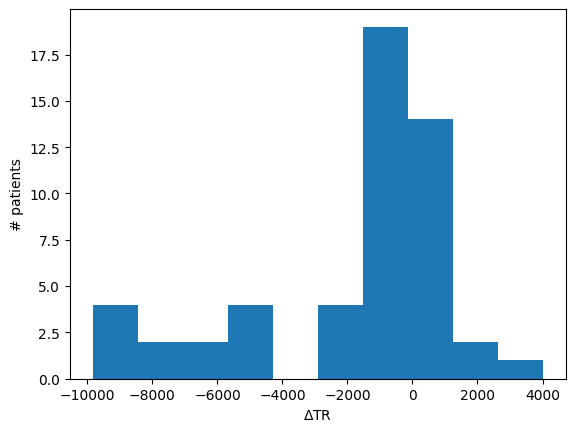

In [711]:
plt.hist(delta_df.delta_TR)
plt.xlabel(r"$\Delta$TR")
plt.ylabel("# patients")

Text(0, 0.5, '# patients')

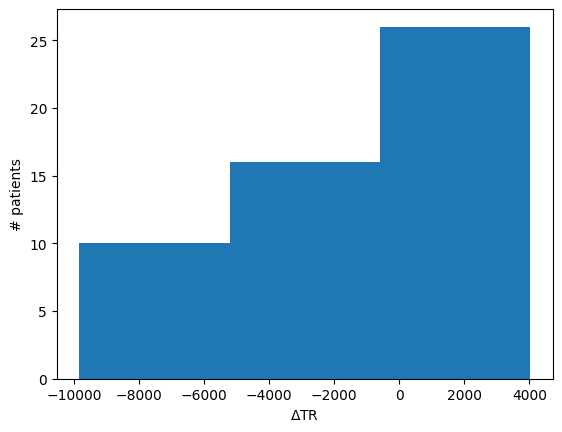

In [712]:
plt.hist(delta_df.delta_TR, bins=3)
plt.xlabel(r"$\Delta$TR")
plt.ylabel("# patients")

In [667]:
SOI = ["t2w_fs", "t2w_nfs"]

# bins = [(-9840, -5216), (-5216, -593), (-593, 4030)]

bins = [(-9840, -4000), (-4000,0), (0,4030)]

# bins = [(-9840., -7066.), (-7066., -4292.), (-4292., -1518.),  (-1518., 1256.),  (1256., 4030.)]

out = {}
tr_impact_df = {"post_process_type":[], "feature":[], "slope":[], "p_value":[]}

for post_process_type in ["combat", "normal"]:
    
    out[post_process_type] = {}

#     stable_features =  non_shape_features # sub_stability_df[(sub_stability_df.type==post_process_type)].feature.to_list()#&(sub_stability_df.ccc>=CCC_threshold)

    _df = sub_feats_df[["id", "sequence"]+non_shape_features].reset_index(drop=True)
    _df["sequence"] = _df["sequence"].apply(lambda x:SOI.index(x))
    
    if post_process_type=="combat":
        
        stable_features = non_shape_features #list(set(non_shape_features)-set(constant_features))
#         constant_df = _df[constant_features].reset_index(drop=True)
        covars_df = _df[["id", "sequence"]].reset_index(drop=True)
        data_df = _df[stable_features].reset_index(drop=True)
        combat_data_npy = neuroCombat(dat=data_df.T, covars = covars_df, batch_col="sequence")["data"].T
        combat_data_df = pd.DataFrame(combat_data_npy, columns = stable_features)
        _df = pd.concat([covars_df, combat_data_df], axis=1)
        

    for feat in tqdm(non_shape_features, position=0, desc=f"processing for post-process:{post_process_type}"):
        
        out[post_process_type][feat] = {}
        
        mean_deltas = []
        ccc_estimates = []
        
        for lb,ub in bins:
            
            mean_delta = (lb+ub)/2
            
            ids = delta_df[delta_df.delta_TR.between(lb, ub)].id.to_list()
            
            __df = _df[_df.id.isin(ids)]
            
            x1 = __df[__df.sequence==SOI.index("t2w_fs")].sort_values(by="id")[feat].values
            x2 = __df[__df.sequence==SOI.index("t2w_nfs")].sort_values(by="id")[feat].values
            
            estimate = ccc(x1, x2)
            
            out[post_process_type][feat][(lb,ub, mean_delta)] = estimate
            
            mean_deltas.append(mean_delta)
            ccc_estimates.append(estimate)
        
        
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(mean_deltas, ccc_estimates)
        tr_impact_df["post_process_type"].append(post_process_type)
        tr_impact_df["feature"].append(feat)
        tr_impact_df["slope"].append(slope)
        tr_impact_df["p_value"].append(p_value)
        
  

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


/home/thulasiseetha/research/venvs/myenv/lib/python3.7/site-packages/neuroCombat/neuroCombat.py:324: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


processing for post-process:combat:   0%|          | 0/1911 [00:00<?, ?it/s]

processing for post-process:normal:   0%|          | 0/1911 [00:00<?, ?it/s]

In [673]:
tr_impact_df = pd.DataFrame(tr_impact_df)
combat_tr_df = tr_impact_df[(tr_impact_df.post_process_type=="combat")][["feature", "slope", "p_value"]]
normal_tr_df = tr_impact_df[(tr_impact_df.post_process_type=="normal")][["feature", "slope", "p_value"]]

combat_tr_df["p_value_corr"] = multipletests(combat_tr_df["p_value"], method="fdr_bh")[1]
normal_tr_df["p_value_corr"] = multipletests(normal_tr_df["p_value"], method="fdr_bh")[1]

In [694]:
excellent_features = sub_stability_df[(sub_stability_df.type=='combat')&(sub_stability_df.ccc>=0.85)].feature.to_list()

In [700]:
combat_tr_df[(combat_tr_df.feature.isin(excellent_features))&(combat_tr_df.p_value<0.05)]

,feature,slope,p_value,p_value_corr
72,original_ngtdm_Busyness,-0.000005,0.024117,0.897895
147,log-sigma-2-0-mm-3D_glszm_GrayLevelNonUniformity,0.000015,0.010437,0.897895
482,wavelet-LLH_glcm_Idm,0.000017,0.002880,0.897895
531,wavelet-LLH_ngtdm_Strength,-0.000016,0.017419,0.897895
800,wavelet-HLL_ngtdm_Busyness,-0.000007,0.009482,0.897895
816,wavelet-HLL_gldm_SmallDependenceEmphasis,-0.000015,0.022130,0.897895
1264,square_gldm_GrayLevelNonUniformity,-0.000013,0.018960,0.897895
1603,gradient_glszm_GrayLevelNonUniformity,0.000020,0.001661,0.897895
1624,gradient_gldm_DependenceEntropy,0.000007,0.001723,0.897895


# Impact of Processing Configurations on Stability

In [ ]:
import statsmodels.formula.api as sm

In [560]:
df = pd.read_csv("results/stability_df.csv")

In [569]:
results = sm.ols(formula="ccc ~ C(bias_correction, Treatment(reference='none')) + C(normalization, Treatment(reference='none')) + C(type, Treatment(reference='normal'))", data = df[df.tissue=='gwm']).fit()

In [570]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    ccc   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     1177.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:08:22   Log-Likelihood:                -663.93
No. Observations:               77000   AIC:                             1346.
Df Residuals:                   76991   BIC:                             1429.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [ ]:
## Sanity Check Power Analysis: Pearson Power Analysis

In [ ]:
# from scipy.stats import pearsonr

# def pearson_coeff(x1, x2):
    
#     r, p_value = pearsonr(x1, x2)
    
#     return r
    
    

In [ ]:
# alpha = 0.05
# r_threshold = 0.85

# power_hist = []
# samples_hist = []

# for num_samples in tqdm([2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,52,55]):

#     p_values = []

#     for i in range(100):

#         x1, x2 = get_random_samples(r_threshold, n_samples=num_samples)

#         p = permutation_test(x1, x2, pearson_coeff)

#         p_values.append(p)
    
#     power = (np.array(p_values)<=alpha).mean()

#     print(f"For {num_samples}, Power= {power}")
    
#     power_hist.append(power)
#     samples_hist.append(num_samples)

In [ ]:
# plt.plot(samples_hist, power_hist, linestyle="-", marker='o', color='black')
# plt.xlabel("# of samples")
# plt.ylabel(r"Power (1-$\beta$)")
# plt.axvline(x=52, linestyle='--', label="# of samples = 52")
# plt.legend()